# Tornado Classification using Quantum Machine Learning 

## Objective
 Our goal is to classify tornadoes based off strength. There are two overlapping objectives. (I) Classify the tornadoes as weak or strong, and (II) Classify tornadoes into specific categories. Weak is defined as anything under an EF of 2, and strong is a tornado of EF 2 or greator. We evaluate the model based off area under the curve (AUC) for the graph of false positive vs true positive. By convention/definition, AUC is between 0.5 (worst case) and 1.0 (best case). We also report a confusion matrix to show how the models perform for each datapoint.

## Features and  Definitions
 
 * **Cape** - Convective Available Potential Energy: measure of
atmospheric instability and thunderstorm potential (J/kg)

* **Cin** - Convective Inhibition: atmospheric energy barrier that
suppresses convective development (J/kg)

* **dewpoint_2m** - 2-meter dewpoint temperature: moisture
content indicator at surface level (°C)

* **temp_2m** - 2-meter air temperature: surface-level atmospheric
temperature measurement (°C)

* **tcwv** - Total Column Water Vapor: integrated atmospheric
moisture content from surface to top of atmosphere (kg/m²)
surface_pressure - Surface atmospheric pressure: weight of air
column at ground level (hPa or mb)

* **shear_0_1km** - Wind shear 0-1km: difference in wind
speed/direction between surface and 1km altitude (m/s)

* **shear_0_3km** - Wind shear 0-3km: difference in wind
speed/direction between surface and 3km altitude (m/s)

* **ef_class** - Enhanced Fujita Scale class: tornado intensity rating from EF0 (weakest) to EF3+ (strongest)

* **ef_binary** - Binary tornado classification: simplified weak (EF0-1) versus strong (EF2+) tornado categories

## GPU Highlights:
Our task and solution would be difficult to solve, and certainly not possible to solve in a reaonable amount of time without GPUs. We highlight the three main areas where GPUs are crucial to our plan:

* **AI Model Training** Our problem is an ML classification challenge. Fundamentally, AI benefits from GPUs because of the heavy linear algebra involved in ML. 

* **Random Shadows** This method requires calculating the expectation value of several observables for each datapoint. Each datum is represented by a single quantum circuit, and each circuit runs multiple observables. In the code below, we run 1000 quantum circuits with 32 observables each. This is considered small. GPU parallelization is imperative to scale this method efficiently.
  
* **Quantum Kernel Estimation** Our quantum pipeline requires QKE, which requires requires a quadratic number of circuit executions compared to the original input in order to estimate the kernel matrix. This method is often bottlenecked because of the time required to simulate quantum hardware. This is difficult with GPUs; it is not a hyperbole to say it is pragmatically impossible on CPUs.
  

## Challenges
We faced a several challenges when approaching this project. The first is the unbalanced training set. The cell below highlights this imbalance


In [1]:
import pandas as pd

threshold = 1
count_strong = 0
count_total = 0

for file in [
    '../2025-Quantathon-Tornado-Q-training_data-640-examples.xlsx',
    '../2025-Quantum-Tornado-Q-test_data-200-examples.xlsx',
    '../2025-Quantum-Tornado-validation_data-160-examples.xlsx'
]:
    df = pd.read_excel(file)
    count_strong += (df['ef_class'] > threshold).sum()
    count_total  += len(df)  # total number of rows, not sum of ef_class

print(f"Strong Tornadoes: {count_strong}, Weak Tornadoes: {count_total - count_strong}, Total: {count_total}")


Strong Tornadoes: 107, Weak Tornadoes: 893, Total: 1000


As seen above, less than 11% of the dataset contains strong tornadoes. To combat this, we used Smote to create synthetic datapoints via k-nearest neighbors, creating a balanced dataset. Another approach we tried was to use Quantum Kernel Estimation (QKE) on the 107 datapoints so that if a binary classification model identified a tornado as strong, QKE could specify 2 or 3. This method, shown in the cell below, is resource intensive, **requiring GPUs because we need a quadratic number of quantum circuit executions for QKE.**

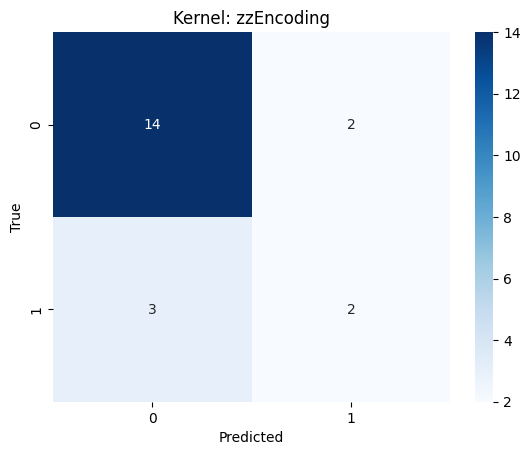

In [2]:
from utils.Helper import removeWeakTornados
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import seaborn as sns
gammas = [50, 45, 40, 35, 30]

encodingSettings = {
    "zzEncoding":True,
    "zzEncoding_full_entangle":False,
}

classicalKernelSettings = {
    "rbf":False,
    "polynomial":False,
}
# Data paths
TRAIN_FILE = '../Data/X_train_scaled.csv'
TEST_FILE = '../Data/X_test_scaled.csv'
LABEL_TRAIN_FILE = '../Data/2025-Quantathon-Tornado-Q-training_data-640-examples.xlsx'
LABEL_TEST_FILE = '../Data/2025-Quantum-Tornado-Q-test_data-200-examples.xlsx'
SAVE_LOCATION = "../Notebooks/kernels/"

df_train = pd.read_csv(TRAIN_FILE)
df_test = pd.read_csv(TEST_FILE)

df_label_train_class = pd.read_excel(LABEL_TRAIN_FILE)["ef_class"]

df_label_test_class = pd.read_excel(LABEL_TEST_FILE)["ef_class"]

df_label_train_class, df_train = removeWeakTornados(df_label_train_class, df_train)
df_label_test_class, df_test = removeWeakTornados(df_label_test_class, df_test)

# Renormalize Data
df_train = df_train.drop(df_train.columns[-1], axis = 1) 
df_train = np.tanh(df_train)
df_test = df_test.drop(df_test.columns[-1], axis = 1)
df_test = np.tanh(df_test)



kernels_train = {}
kernels_test = {}
for kernel in encodingSettings:
    if encodingSettings[kernel]:
        kernels_train[kernel] = np.load(SAVE_LOCATION + kernel + "_kernel_train.npy", allow_pickle=True)
        kernels_test[kernel] = np.load(SAVE_LOCATION + kernel + "_kernel_test.npy", allow_pickle=True)

classical_kernels_train = {}
classical_kernels_test = {}
for kernel in classicalKernelSettings:
    if classicalKernelSettings[kernel]:
        for gamma in gammas:
            classical_kernels_train[kernel, gamma] = np.load(SAVE_LOCATION + kernel + f"_gamma={gamma}_kernel_train.npy", allow_pickle=True)
            classical_kernels_test[kernel, gamma] = np.load(SAVE_LOCATION + kernel + f"_gamma={gamma}_kernel_test.npy", allow_pickle=True)

kernels_train = kernels_train | classical_kernels_train
kernels_test = kernels_test | classical_kernels_test

classifiers = {}
for kernel in kernels_train:
        if type(kernel) != tuple:
                svc = SVC(kernel="precomputed", class_weight="balanced", probability=True)
                svc.fit(kernels_train[kernel], df_label_train_class)
                classifiers[kernel] = svc
        else:
                svc = SVC(kernel="precomputed", class_weight="balanced", probability=True)
                svc.fit(classical_kernels_train[kernel].item()[kernel[1]], df_label_train_class)
                classifiers[kernel] = svc




#Analyze Data:
# Predictions
predictions = {}
probs = {}
for classifier in classifiers:
    if type(classifier) != tuple:
        predictions[classifier]=classifiers[classifier].predict(kernels_test[classifier])
        probs[classifier]=classifiers[classifier].predict_proba(kernels_test[classifier])
    else:
        predictions[classifier]=classifiers[classifier].predict(kernels_test[classifier].item()[classifier[1]])
        probs[classifier]=classifiers[classifier].predict_proba(kernels_test[classifier].item()[classifier[1]])

# Confusion matrix
cm = {}
for prediction in predictions:  
    cm[prediction] = confusion_matrix(df_label_test_class, predictions[prediction])

# Plot with seaborn
for c in cm:
    sns.heatmap(cm[c], annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Kernel: {c}")
    plt.show()



As many with machine learning experience can quickly notice, 8 (removing EF class and EF binary) features and 1000 datapoints is an extremely small dataset. We use a method known as "random shadows" to create more features. A simple explanation of this is as follows: we take each feature and project it into a higher-dimensional space and then look at the "shadow" cast from different angles. These shadows are expectation values for different bases, which can act as features themselves. This allows us to enhance our feature space from 8 features to 40 features, giving the model a richer set of representations to learn from. It is important to note that we can scale significantly further than 40 features. This arbitrary number was chosen to fit with the constraints of available resources. Even more features would increase the need for GPU resources.

We identify two imperative use cases for GPUs here:

* **Model training efficiency**: Increasing the number of features expands the input space and makes the dataset more complex, amplifying the computational demands of training. This naturally increases the benefits of GPU acceleration for tasks like batch processing, larger batch sizes, and deeper epochs during optimization.

* **Post-processing of the random shadows**: Once the quantum device provides measurement outcomes, the heavy lifting becomes entirely classical. Computing expectation values, reconstructing observables, and generating shadow-based features all involve large, independent linear-algebraic operations—perfectly suited for GPUs. Each shadow can be processed in parallel, and thousands of random bases can be handled simultaneously. This allows GPUs to accelerate the transformation from raw quantum measurements to classical feature vectors, turning quantum-generated data into usable machine-learning inputs in real time.

To illustrate the computational intensity of the post-processing stage, consider a system with $n=20$ qubits, $m=10^5$ measurement shots, and 
$M=5000$ (potential features). The total number of independent operations required to estimate all observables is approximately: $m×M=10^5×5000=5×10^8$

These are small, independent computations — precisely the kind of workload that benefits from GPU parallelism. A modern GPU such as the NVIDIA A100, capable of roughly 20 TFLOP/s, can perform on the order of $10^{12}$ floating-point operations per second. This means that processing $5×10^8$ operations can be completed in milliseconds. To put this into persepctive, generating 32 features for the entire 1000 point dataset took roughly 10-12 minutes on a cpu.

In practice, this enables near real-time transformation of quantum measurement data into classical feature vectors. As the number of features or qubits increases, GPU acceleration becomes not only advantageous but essential for maintaining feasible post-processing times.

For small workloads (such as ours), the fixed overhead of GPU data transfer and kernel launch time dominates the total runtime, leading to similar performance as CPU computation. However, as the dataset or number of observables scales, the arithmetic intensity (ratio of computation to memory transfer) increases, allowing GPUs to fully utilize their parallel throughput.

The cell below gives a short demonstration of creating random shadows. To run the cell, uncomment it. (It may take up to 30ish minutes to run. The rest of the notebook can be run without this cell.)

In [3]:
# from utils import shadows as sh
# from utils.circuits import build_circuit
# import pandas as pd
# import time

# def normalize_new_features(unnormalized_features):
#     from sklearn.preprocessing import MinMaxScaler

#     scaler = MinMaxScaler(feature_range=(0,1))

#     normalized_features = scaler.fit_transform(unnormalized_features)
#     return normalized_features


# # Define the observables we will use for random shadows.
# ring_paulis = 'XY'

# # Import a ready to use data set
# df_train = pd.read_csv('../Data/X_train_scaled.csv')
# df_val = pd.read_csv('../Data/X_val_scaled.csv')
# df_test = pd.read_csv('../Data/X_test_scaled.csv')

# # We combine the entire dataset into one dataframe
# df = pd.concat([df_train, df_val, df_test], ignore_index= True)

# # We have an irrelevant feature at the end, which we drop
# df.drop(df.columns[-1], axis = 1, inplace = True)

# # Convert the data to a numpy array
# data = df.to_numpy()

# # n defines the number of qubits. This is 1 qubit per feature
# n = len(data[0])

# # Each data point gets a circuit
# circuits = [build_circuit(x, entanglement='full', gate='cx', num_layers = 1) for x in data]


# print(f"We have {len(circuits)} {n} qubit circuits. We will need to run each 32 times to generate 32 new features.")

# # This creates the 32 observables to measure the expectation value of.
# paulis = sh.paulis_singles_xyz(n) + sh.paulis_ring_pairs(n, (ring_paulis[0], ring_paulis[1]))

# # This is just some configuration for the backend.
# cfg = sh.ShadowConfig(T=200, shots = 1000, seed = 123)

# # This is where the random shadow measurements actually happen
# start_gpu_clock = time.time()
# new_features = sh.build_feature_matrix_from_circuits(circuits, paulis, cfg, device = 'GPU')
# end_gpu_clock = time.time()

# print(f"Random Shadow Generation: {len(paulis)} observables, {len(circuits)} {n} qubit circuits")
# print(f"GPU Time: {(end_gpu_clock - start_gpu_clock):.2f} seconds")

# # This is the same thing as above but using CPU to show time difference
# start_cpu_clock = time.time()
# new_features = sh.build_feature_matrix_from_circuits(circuits, paulis, cfg, device = 'CPU')
# end_cpu_clock = time.time()

# print(f"CPU Time: {(end_cpu_clock - start_cpu_clock):.2f} seconds")

# # Normalize the new features
# normalized_features = normalize_new_features(new_features)

# df_random_shadows = pd.DataFrame(normalized_features)
# df_random_shadows.to_csv(f"./random_shadow_features")

# Trained Models

## Classical Binary Model

We have two classical models which serve as a baseline for our hybrid and quantum models. The first of the two is the binary classification model. It will classify tornadoes as "weak" or strong" where "weak" is defined as EF 0 and EF 1, and "strong" is categorized as EF 2 and EF 3. We showcase this model in the cells below. 

In [4]:
from utils.model_definitions import BinaryDNN_classical
import torch
from utils.imports import *
from utils.Preprocessing import *
from utils.Helper import *
device = "cuda" if torch.cuda.is_available() else "cpu"
DNN = BinaryDNN_classical().to(device)

load_path = "checkpoints/Binary_DNN_FULLENT_AUC.6993.1011_0915.pt"

# Load the checkpoint
checkpoint = torch.load(load_path)

# Restore model weights
DNN.load_state_dict(checkpoint["DNN_state_dict"])
    
print(f"Loaded model from {load_path}")

Loaded model from checkpoints/Binary_DNN_FULLENT_AUC.6993.1011_0915.pt


In [5]:
import pandas as pd
from utils.Preprocessing import Preprocess, ClassificationDataset, DataLoader
TRAIN_FILE = '../Data/2025-Quantathon-Tornado-Q-training_data-640-examples.xlsx'
TEST_FILE = '../Data/2025-Quantum-Tornado-Q-test_data-200-examples.xlsx'
VALIDATION_FILE = '../Data/2025-Quantum-Tornado-validation_data-160-examples.xlsx'

# Load training data
df_train = pd.read_excel(TRAIN_FILE)
# Load test data
df_test = pd.read_excel(TEST_FILE)
# Load validation data
df_val = pd.read_excel(VALIDATION_FILE)

# Define variable and dataset
batch_size = 64
lr = 1e-2

X_train, y_train, X_test, y_test, X_val, y_val = Preprocess(df_train, df_test, df_val, balance = 'smote', classes = 'binary')

print(y_test[:])
print(y_train[:])
print(y_val[:])

train_data = ClassificationDataset(X_train, y_train)
validation_data = ClassificationDataset(X_val, y_val)
test_data = ClassificationDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(validation_data, batch_size=64, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, drop_last=True)

X_batch, y_batch = next(iter(train_loader))

0      0
1      0
2      0
3      0
4      1
      ..
195    0
196    0
197    1
198    0
199    0
Name: ef_binary, Length: 200, dtype: int64
0       0
1       0
2       0
3       0
4       0
       ..
1137    1
1138    1
1139    1
1140    1
1141    1
Name: ef_binary, Length: 1142, dtype: int64
0      0
1      0
2      1
3      0
4      0
      ..
155    0
156    0
157    0
158    0
159    0
Name: ef_binary, Length: 160, dtype: int64


(192,) (192,) (192,)
[0 1]
AUC: 0.6404, F1: 0.2222, Accuracy: 0.7812, CSI: 0.1250


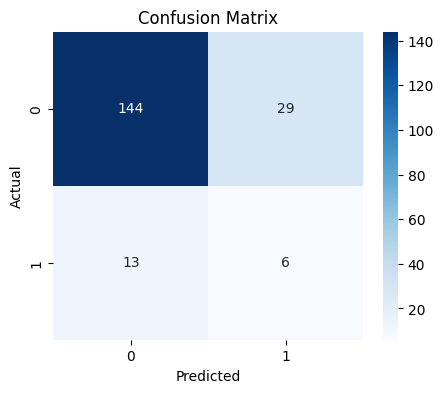

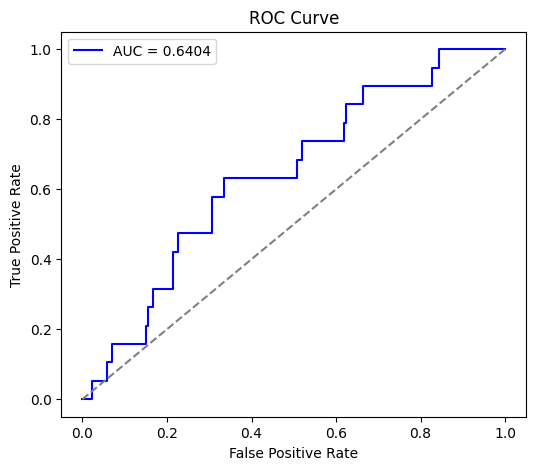

In [6]:
# --- Set model to evaluation mode ---
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from utils.Helper import plot_confusion_matrix
DNN.eval()

all_targets = []
all_preds = []
all_outputs = []

with torch.no_grad():
    for features, target in test_loader:
        features = features.to(device)
        target = target.to(device).float().unsqueeze(-1)

        outputs = DNN(features)
        preds = (outputs > 0.5).float()

        all_targets.append(target.cpu())
        all_preds.append(preds.cpu())
        all_outputs.append(outputs.cpu())

# --- Concatenate all batches ---
all_targets = torch.cat(all_targets).squeeze().long().numpy()  # integers 0/1
all_preds = torch.cat(all_preds).squeeze().long().numpy()
all_outputs = torch.cat(all_outputs).squeeze().numpy()             # floats in [0,1]

# --- Sanity check ---
print(all_targets.shape, all_preds.shape, all_outputs.shape)
print(np.unique(all_targets))  # should be [0,1]

# --- Compute Metrics ---
cm = confusion_matrix(all_targets, all_preds)
auc_score = roc_auc_score(all_targets, all_outputs)  # should work now
f1 = f1_score(all_targets, all_preds)
acc = accuracy_score(all_targets, all_preds)

# Critical Success Index (CSI)
tp = cm[1,1]
fn = cm[1,0]
fp = cm[0,1]
csi = tp / (tp + fn + fp)

print(f"AUC: {auc_score:.4f}, F1: {f1:.4f}, Accuracy: {acc:.4f}, CSI: {csi:.4f}")

# --- Plot Confusion Matrix ---
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# --- Plot ROC Curve ---
fpr, tpr, thresholds = roc_curve(all_targets, all_outputs)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}', color='blue')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()



# Interpreting the Results
The above cell generated a few images. The confusion matrix is easily interpretable, the line graph of False Positive vs True Positive serves as a baseline classical solution with a trivial 0.6404 or 64%. The best value here is 1, and the worst is 0.5 because it indicates random guessing. We see the classical model does mediocre at best. As it turns out, this problem is quite challenging.

# Multi Class Classical Model

The next model is a similar classical model. The main difference is that this one categorizes into individual EF categories instead of just "weak"(0) or "strong"(1) in the model above.

In [7]:
# Load training data
df_train = pd.read_excel(TRAIN_FILE)
# Load test data
df_test = pd.read_excel(TEST_FILE)
# Load validation data
df_val = pd.read_excel(VALIDATION_FILE)



X_train, y_train, X_test, y_test, X_val, y_val = Preprocess(df_train, df_test, df_val, balance = 'smote', classes = 'multiclass')

train_data = ClassificationDataset(X_train, y_train)
validation_data = ClassificationDataset(X_val, y_val)
test_data = ClassificationDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(validation_data, batch_size=64, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, drop_last=True)

X_batch, y_batch = next(iter(train_loader))


AUC: 0.5543, F1: 0.3449, Accuracy: 0.5365
Class 0 CSI: 0.5299
Class 1 CSI: 0.2796
Class 2 CSI: 0.1429
Class 3 CSI: 0.0000


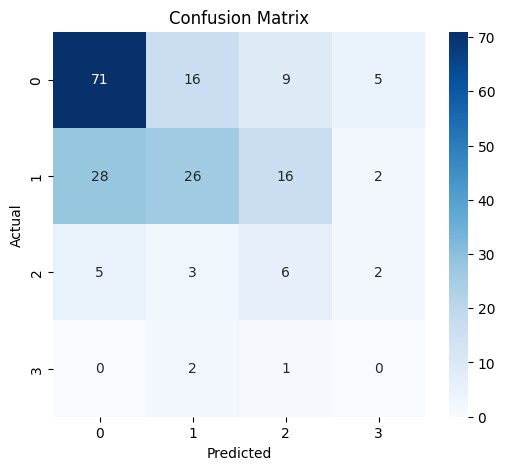

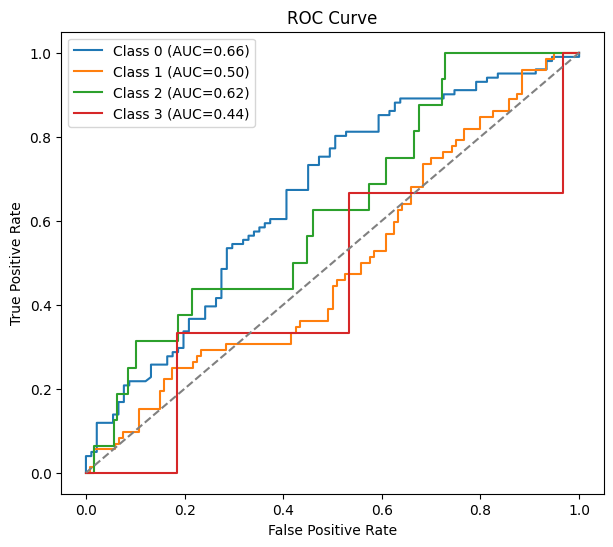

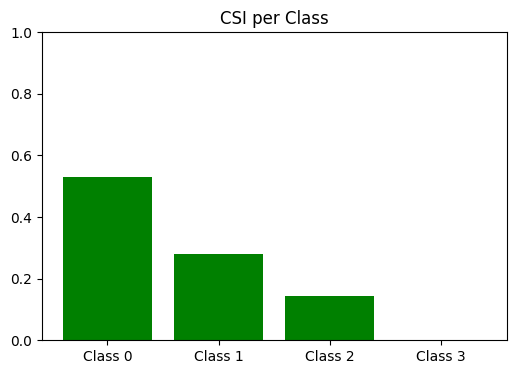

In [8]:
from utils.model_definitions import MultiClassDNN_classical

DNN = MultiClassDNN_classical().to(device)

load_path = "checkpoints/Multiclass_DNN_3Layer_AUC.8.1011_1012.pt"

# Load the checkpoint
checkpoint = torch.load(load_path)

# Restore model weights
DNN.load_state_dict(checkpoint["DNN_state_dict"])

DNN.eval()
all_targets, all_preds, all_probs = [], [], []

with torch.no_grad():
    for features, target in test_loader:
        features = features.to(device)
        target = target.to(device).long()
        outputs = DNN(features)
        
        if outputs.shape[1] == 1:
            # Binary case
            probs = torch.sigmoid(outputs).squeeze(-1)
            preds = (probs > 0.5).long()
        else:
            # Multiclass case
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

        all_targets.append(target.cpu())
        all_preds.append(preds.cpu())
        all_probs.append(probs.cpu())

# Concatenate
all_targets = torch.cat(all_targets).numpy()
all_preds = torch.cat(all_preds).numpy()
all_probs = torch.cat(all_probs).numpy()

# Metrics
cm = confusion_matrix(all_targets, all_preds)
acc = accuracy_score(all_targets, all_preds)
if outputs.shape[1] == 1:
    f1 = f1_score(all_targets, all_preds)
    auc_score = roc_auc_score(all_targets, all_probs)
    csi = cm[1,1] / (cm[1,1] + cm[1,0] + cm[0,1])
else:
    num_classes = outputs.shape[1]
    f1 = f1_score(all_targets, all_preds, average='macro')
    auc_score = roc_auc_score(np.eye(num_classes)[all_targets], all_probs, multi_class='ovr')
    csi = []
    for i in range(num_classes):
        tp = cm[i,i]
        fn = cm[i,:].sum() - tp
        fp = cm[:,i].sum() - tp
        csi.append(tp / (tp + fn + fp) if (tp+fn+fp)>0 else 0)

# Print metrics
print(f"AUC: {auc_score:.4f}, F1: {f1:.4f}, Accuracy: {acc:.4f}")
if outputs.shape[1] > 1:
    for i, c in enumerate(csi):
        print(f"Class {i} CSI: {c:.4f}")
else:
    print(f"CSI: {csi:.4f}")

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC curve
plt.figure(figsize=(7,6))
if outputs.shape[1] == 1:
    fpr, tpr, _ = roc_curve(all_targets, all_probs)
    plt.plot(fpr, tpr, label=f'AUC={auc_score:.4f}')
else:
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve((all_targets==i).astype(int), all_probs[:,i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# CSI bar for multiclass
if outputs.shape[1] > 1:
    plt.figure(figsize=(6,4))
    plt.bar([f'Class {i}' for i in range(num_classes)], csi, color='green')
    plt.ylim(0,1)
    plt.title('CSI per Class')
    plt.show()


# Interpreting the Multi Class Classical Results
We can see that this model does not do much better. Each individual class is an EF category and the value reported (AUC) is related to how many tornadoes it categorized right in that category. The case of EF 3 is interesting as it does worse than simply "random guessing.

# Hybrid Binary Model
This model classifies into weak and strong binaries. The approach here was to use random shadows to look at the features from different angles. These shadows are then used in conjunction with the original features to create a dataset with 40 features per datum instead of just 8. The AI model itself is the same as the above ones. The quantum component is the feature engineering.

In [9]:
TRAIN_FILE = '../Data/2025-Quantathon-Tornado-Q-training_data-640-examples.xlsx'
TEST_FILE = '../Data/2025-Quantum-Tornado-Q-test_data-200-examples.xlsx'
VALIDATION_FILE = '../Data/2025-Quantum-Tornado-validation_data-160-examples.xlsx'

# Load training data
df_train = pd.read_excel(TRAIN_FILE)
# Load test data
df_test = pd.read_excel(TEST_FILE)
# Load validation data
df_val = pd.read_excel(VALIDATION_FILE)

# Quantum augmented datasets using random shadows
EXTRA_TRAIN = "../Data/36_featuresXY_train_QuantumLayers3.csv"
EXTRA_TEST  = "../Data/36_featuresXY_test_QuantumLayers3.csv"
EXTRA_VALID = "../Data/36_featuresXY_val_QuantumLayers3.csv"

# Extra features
extra_train_df = pd.read_csv(EXTRA_TRAIN)
extra_test_df = pd.read_csv(EXTRA_TEST)
extra_valid_df = pd.read_csv(EXTRA_VALID)

# Drop first column by index
extra_train_df = extra_train_df.drop(extra_train_df.columns[0], axis=1)
extra_test_df = extra_test_df.drop(extra_test_df.columns[0], axis=1)
extra_valid_df = extra_valid_df.drop(extra_valid_df.columns[0], axis=1)

# Concatenate extra features (axis=1 for columns)
df_train = pd.concat([df_train, extra_train_df], axis=1)
df_test  = pd.concat([df_test, extra_test_df], axis=1)
df_val  = pd.concat([df_val, extra_valid_df], axis=1)

In [10]:
X_train, y_train, X_test, y_test, X_val, y_val = Preprocess(df_train, df_test, df_val, balance = 'smote', classes = 'binary')

train_data = ClassificationDataset(X_train, y_train)
validation_data = ClassificationDataset(X_val, y_val)
test_data = ClassificationDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(validation_data, batch_size=64, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, drop_last=True)

X_batch, y_batch = next(iter(train_loader))

In [11]:
from utils.model_definitions import BinaryDNN_Hybrid
DNN = BinaryDNN_Hybrid().to(device)

load_path = '../Notebooks/models/Binary_DNN_FULLENT_AUC.6993.1011_0853.pt' # Working Best

checkpoint = torch.load(load_path, map_location=device)

# Restore model weights
DNN.load_state_dict(checkpoint["DNN_state_dict"])


<All keys matched successfully>

(192,) (192,) (192,)
[0 1]
AUC: 0.6234, F1: 0.0000, Accuracy: 0.9010, CSI: 0.0000


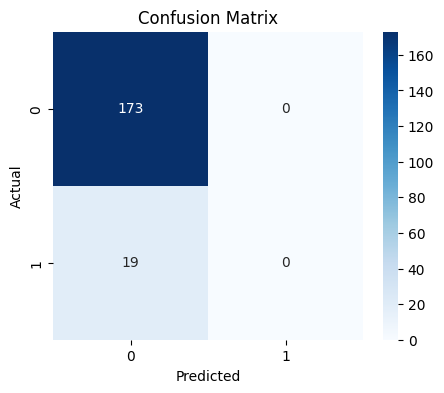

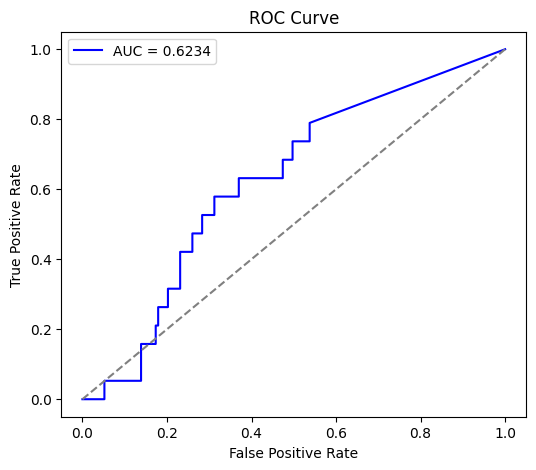

In [12]:
# --- Set model to evaluation mode ---
DNN.eval()

all_targets = []
all_preds = []
all_outputs = []

with torch.no_grad():
    for features, target in test_loader:
        features = features.to(device)
        target = target.to(device).float().unsqueeze(-1)

        outputs = DNN(features)
        preds = (outputs > 0.5).float()

        all_targets.append(target.cpu())
        all_preds.append(preds.cpu())
        all_outputs.append(outputs.cpu())

# --- Concatenate all batches ---
all_targets = torch.cat(all_targets).squeeze().long().numpy()  # integers 0/1
all_preds = torch.cat(all_preds).squeeze().long().numpy()
all_outputs = torch.cat(all_outputs).squeeze().numpy()             # floats in [0,1]

# --- Sanity check ---
print(all_targets.shape, all_preds.shape, all_outputs.shape)
print(np.unique(all_targets))  # should be [0,1]

# --- Compute Metrics ---
cm = confusion_matrix(all_targets, all_preds)
auc_score = roc_auc_score(all_targets, all_outputs)  # should work now
f1 = f1_score(all_targets, all_preds)
acc = accuracy_score(all_targets, all_preds)

# Critical Success Index (CSI)
tp = cm[1,1]
fn = cm[1,0]
fp = cm[0,1]
csi = tp / (tp + fn + fp)

print(f"AUC: {auc_score:.4f}, F1: {f1:.4f}, Accuracy: {acc:.4f}, CSI: {csi:.4f}")

# --- Plot Confusion Matrix ---
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# --- Plot ROC Curve ---
fpr, tpr, thresholds = roc_curve(all_targets, all_outputs)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}', color='blue')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


# Results Hybrid Binary Model

The AUC here is quite comparable to the original model, suggesting that the extra features do not add anything for the binary problem.

# Multi Class Hybrid Mode

The next model is the same as above, except for individual EF categories.

In [13]:
# Data paths
TRAIN_FILE = '../Data/2025-Quantathon-Tornado-Q-training_data-640-examples.xlsx'
TEST_FILE = '../Data/2025-Quantum-Tornado-Q-test_data-200-examples.xlsx'
VALIDATION_FILE = '../Data/2025-Quantum-Tornado-validation_data-160-examples.xlsx'

# Load training data
df_train = pd.read_excel(TRAIN_FILE)
# Load test data
df_test = pd.read_excel(TEST_FILE)
# Load validation data
df_val = pd.read_excel(VALIDATION_FILE)

if True:
    # Quantum augmented datasets using random shadows
    EXTRA_TRAIN = "../Data/36_featuresXY_train_QuantumLayers3.csv"
    EXTRA_TEST  = "../Data/36_featuresXY_test_QuantumLayers3.csv"
    EXTRA_VALID = "../Data/36_featuresXY_val_QuantumLayers3.csv"
    
    # Extra features
    extra_train_df = pd.read_csv(EXTRA_TRAIN)
    extra_test_df = pd.read_csv(EXTRA_TEST)
    extra_valid_df = pd.read_csv(EXTRA_VALID)
    
    # Drop first column by index
    extra_train_df = extra_train_df.drop(extra_train_df.columns[0], axis=1)
    extra_test_df = extra_test_df.drop(extra_test_df.columns[0], axis=1)
    extra_valid_df = extra_valid_df.drop(extra_valid_df.columns[0], axis=1)
    
    # Concatenate extra features (axis=1 for columns)
    df_train = pd.concat([df_train, extra_train_df], axis=1)
    df_test  = pd.concat([df_test, extra_test_df], axis=1)
    df_val  = pd.concat([df_val, extra_valid_df], axis=1)

In [14]:
from utils.model_definitions import MulticlassDNN_Hybrid

DNN = MulticlassDNN_Hybrid().to(device)


# load_path = "checkpoints/Multiclass_DNN_3Layer_AUC.8.best_1011_1053.pt" # Working

load_path = "../Notebooks/models/DNN_multiclass_best_accuracy.pt"
# Load the checkpoint
checkpoint = torch.load(load_path)

# Restore model weights
DNN.load_state_dict(checkpoint["DNN_state_dict"])
    
print(f"Loaded model from {load_path}")


X_train, y_train, X_test, y_test, X_val, y_val = Preprocess(df_train, df_test, df_val, balance = 'smote', classes = 'multiclass')

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

print(y_test[:])
print(y_train[:])
print(y_val[:])

train_data = ClassificationDataset(X_train, y_train)
validation_data = ClassificationDataset(X_val, y_val)
test_data = ClassificationDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(validation_data, batch_size=64, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, drop_last=True)

X_batch, y_batch = next(iter(train_loader))




Loaded model from ../Notebooks/models/DNN_multiclass_best_accuracy.pt
(1328, 43) (1328,)
(160, 43) (160,)
(200, 43) (200,)
0      1
1      0
2      1
3      0
4      2
      ..
195    1
196    1
197    3
198    0
199    0
Name: ef_class, Length: 200, dtype: int64
0       1
1       0
2       1
3       0
4       1
       ..
1323    3
1324    3
1325    3
1326    3
1327    3
Name: ef_class, Length: 1328, dtype: int64
0      0
1      1
2      2
3      0
4      0
      ..
155    0
156    1
157    0
158    0
159    1
Name: ef_class, Length: 160, dtype: int64


AUC: 0.6714, F1: 0.3140, Accuracy: 0.5729
Class 0 CSI: 0.5278
Class 1 CSI: 0.3173
Class 2 CSI: 0.0435
Class 3 CSI: 0.0000


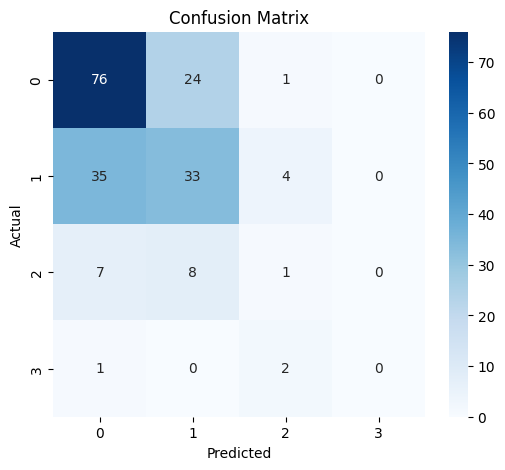

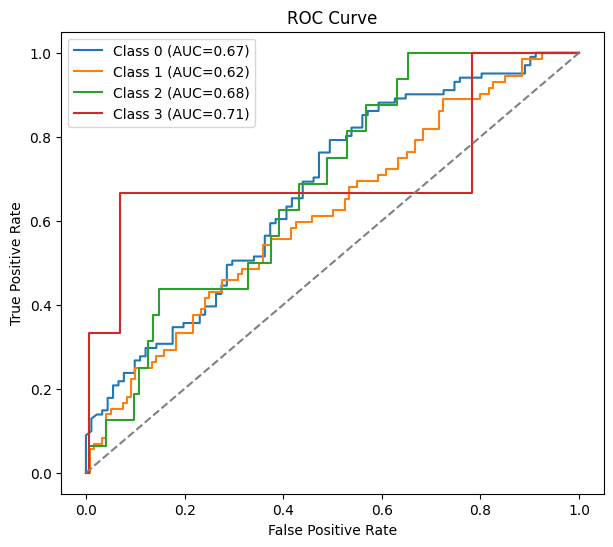

In [15]:
all_targets, all_preds, all_probs = [], [], []

with torch.no_grad():
    for features, target in test_loader:
        features = features.to(device)
        target = target.to(device).long()
        outputs = DNN(features)
        
        if outputs.shape[1] == 1:
            # Binary case
            probs = torch.sigmoid(outputs).squeeze(-1)
            preds = (probs > 0.5).long()
        else:
            # Multiclass case
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

        all_targets.append(target.cpu())
        all_preds.append(preds.cpu())
        all_probs.append(probs.cpu())

# Concatenate
all_targets = torch.cat(all_targets).numpy()
all_preds = torch.cat(all_preds).numpy()
all_probs = torch.cat(all_probs).numpy()

# Metrics
cm = confusion_matrix(all_targets, all_preds)
acc = accuracy_score(all_targets, all_preds)
if outputs.shape[1] == 1:
    f1 = f1_score(all_targets, all_preds)
    auc_score = roc_auc_score(all_targets, all_probs)
    csi = cm[1,1] / (cm[1,1] + cm[1,0] + cm[0,1])
else:
    num_classes = outputs.shape[1]
    f1 = f1_score(all_targets, all_preds, average='macro')
    auc_score = roc_auc_score(np.eye(num_classes)[all_targets], all_probs, multi_class='ovr')
    csi = []
    for i in range(num_classes):
        tp = cm[i,i]
        fn = cm[i,:].sum() - tp
        fp = cm[:,i].sum() - tp
        csi.append(tp / (tp + fn + fp) if (tp+fn+fp)>0 else 0)

# Print metrics
print(f"AUC: {auc_score:.4f}, F1: {f1:.4f}, Accuracy: {acc:.4f}")
if outputs.shape[1] > 1:
    for i, c in enumerate(csi):
        print(f"Class {i} CSI: {c:.4f}")
else:
    print(f"CSI: {csi:.4f}")

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC curve
plt.figure(figsize=(7,6))
if outputs.shape[1] == 1:
    fpr, tpr, _ = roc_curve(all_targets, all_probs)
    plt.plot(fpr, tpr, label=f'AUC={auc_score:.4f}')
else:
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve((all_targets==i).astype(int), all_probs[:,i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Interpreting the results Hybrid Multi Class
Immediately, we see that the class 3 tornadoes are classified more accurately the the original classical multi class model. These are the most dangerous tornadoes! Even an AUC of 0.6 for Class 3 compared to the original ( < 0.5) is significant when it comes to saving lives.

The classical model had the follow AUCs:
* **Class 0:**  0.66
* **Class 1:**  0.50
* **Class 2:**  0.62
* **Class 3:**  0.44

The hybrid model does noticably better than the classical multiclass model.

# Binary Parameterized Quantum Circuit (PQC)
This model is fully quantum.

Single state shape: torch.Size([256])
Batch output shape: torch.Size([16, 256])


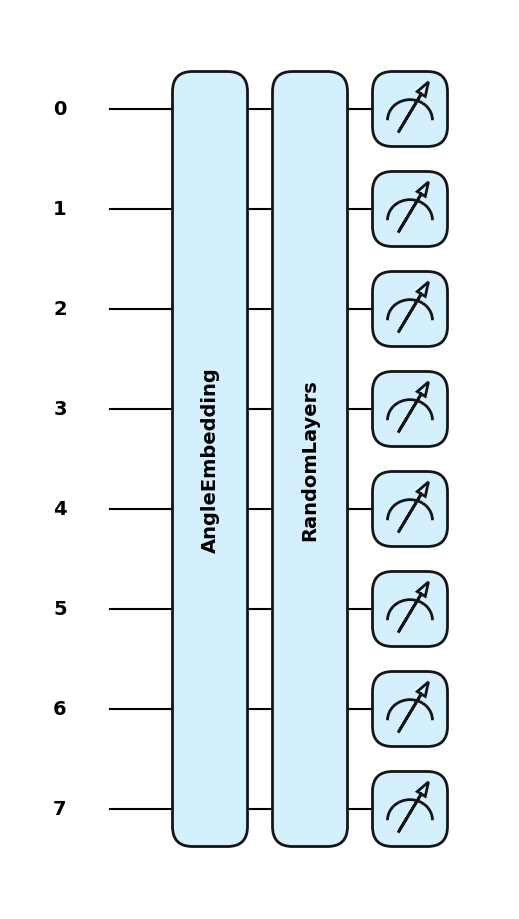

In [16]:
# Load dataset and device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data paths
TRAIN_FILE = '../Data/2025-Quantathon-Tornado-Q-training_data-640-examples.xlsx'
TEST_FILE = '../Data/2025-Quantum-Tornado-Q-test_data-200-examples.xlsx'
VALIDATION_FILE = '../Data/2025-Quantum-Tornado-validation_data-160-examples.xlsx'

# Load training data
df_train = pd.read_excel(TRAIN_FILE)
# Load test data
df_test = pd.read_excel(TEST_FILE)
# Load validation data
df_val = pd.read_excel(VALIDATION_FILE)

# Quantum device and parameters
n_qubits = 8
n_layers = 1
dev = qml.device("default.qubit", wires=n_qubits)

# Using Random Layers PQC
USE_RANDOM = True

if USE_RANDOM:
    # RandomLayers expects shape (n_layers, n_rotations_per_layer)
    # For 8 qubits, each layer typically has 3 * 8 = 24 rotations
    rand_params = np.random.uniform(0, 2 * np.pi, (n_layers, n_qubits * 3))

    @qml.qnode(dev, interface="torch", diff_method="backprop")
    def quantum_feature_embedding(f, phi):
        qml.AngleEmbedding(features=f, wires=range(n_qubits))
        RandomLayers(phi, wires=range(n_qubits), seed=6)
        return qml.state()  # returns 2**n_qubits = 256-dim statevector

# Using Strongly Entangling Layers
else:
    # StronglyEntanglingLayers expects shape (n_layers, n_wires, 3)
    rand_params = np.random.uniform(0, 2 * np.pi, (n_layers, n_qubits, 3))

    @qml.qnode(dev, interface="torch", diff_method="backprop")
    def quantum_feature_embedding(f, phi):
        qml.AngleEmbedding(features=f, wires=range(n_qubits))
        qml.StronglyEntanglingLayers(weights=phi, wires=range(n_qubits))
        return qml.state()

# Batched embedding helper
def quantum_feature_embedding_batch(x_batch, phi, device="cuda"):
    """Apply QNode to batch of inputs -> (B, 256)"""
    outputs = []
    phi = phi.detach().cpu()
    for x in x_batch:
        result = quantum_feature_embedding(x.detach().cpu(), phi)
        outputs.append(result.real.to(device))
    return torch.stack(outputs)

# Test single example
state = quantum_feature_embedding(
    torch.tensor([1/4] * n_qubits, dtype=torch.float32),
    torch.tensor(rand_params, dtype=torch.float32)
)
print("Single state shape:", state.shape)  # (256,)

# Test batch
sample = torch.randn(16, n_qubits)
phi_tensor = torch.tensor(rand_params, dtype=torch.float32)
output = quantum_feature_embedding_batch(sample, phi_tensor, device = device)
print("Batch output shape:", output.shape)  # (16, 256)

# Torch module for integration
class QuantumFeatureEmbeddingBatch(nn.Module):
    def __init__(self, device="cuda"):
        super().__init__()
        self.device = device
        self.phi = nn.Parameter(torch.tensor(
            np.random.uniform(0, 2 * np.pi, (n_layers, n_qubits * 3)), 
            dtype=torch.float32
        ))

    def forward(self, x_batch):
        outputs = []
        phi = self.phi.detach().cpu()
        for x in x_batch:
            result = quantum_feature_embedding(x.detach().cpu(), phi)
            outputs.append(result.real.to(self.device))
        return torch.stack(outputs)

# Visualize
qml.drawer.use_style('pennylane')
fig, ax = qml.draw_mpl(quantum_feature_embedding, level="device")(f=[1/4]*n_qubits, phi=rand_params)
fig.show()


In [17]:

# Binary DN with Quantum Random Layer feature encoder
class BinaryPQC(nn.Module):
    def __init__(self):
        super().__init__()

        # Encodes features from dataset
        self.feature_encoder = QuantumFeatureEmbeddingBatch(device=device)

        # Classifies based on encoded features
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, features):
        feats_encoded = self.feature_encoder(features)
        class_probs = self.classifier(feats_encoded.float())

        return class_probs  # Shape: (batch_size, 1)
    
DNN = BinaryPQC().to(device)
    
load_path = "checkpoints/DNN_model_best_accuracy.pt" # Path to load model

# Load the checkpoint
checkpoint = torch.load(load_path, map_location=device)

# Restore model weights
DNN.load_state_dict(checkpoint["DNN_state_dict"])
    
print(f"Loaded model from {load_path}")
    


    
X_train, y_train, X_test, y_test, X_val, y_val = Preprocess(df_train, df_test, df_val, balance = 'smote', classes = 'binary')


train_data = ClassificationDataset(X_train, y_train)
validation_data = ClassificationDataset(X_val, y_val)
test_data = ClassificationDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(validation_data, batch_size=64, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, drop_last=True)

X_batch, y_batch = next(iter(train_loader))

Loaded model from checkpoints/DNN_model_best_accuracy.pt


(192,) (192,) (192,)
[0 1]
AUC: 0.7378, F1: 0.2979, Accuracy: 0.8281, CSI: 0.1750


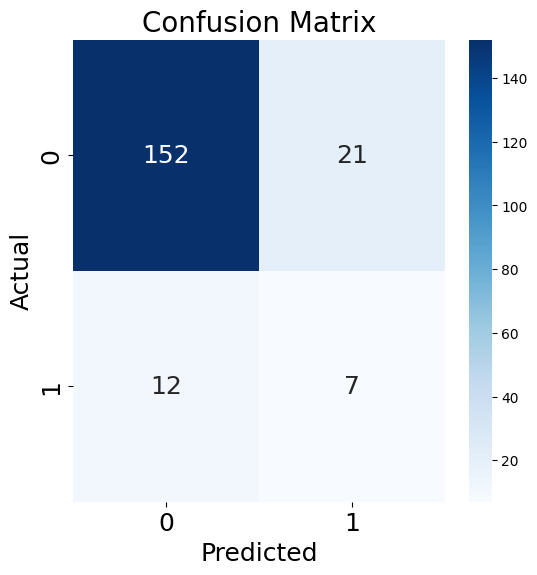

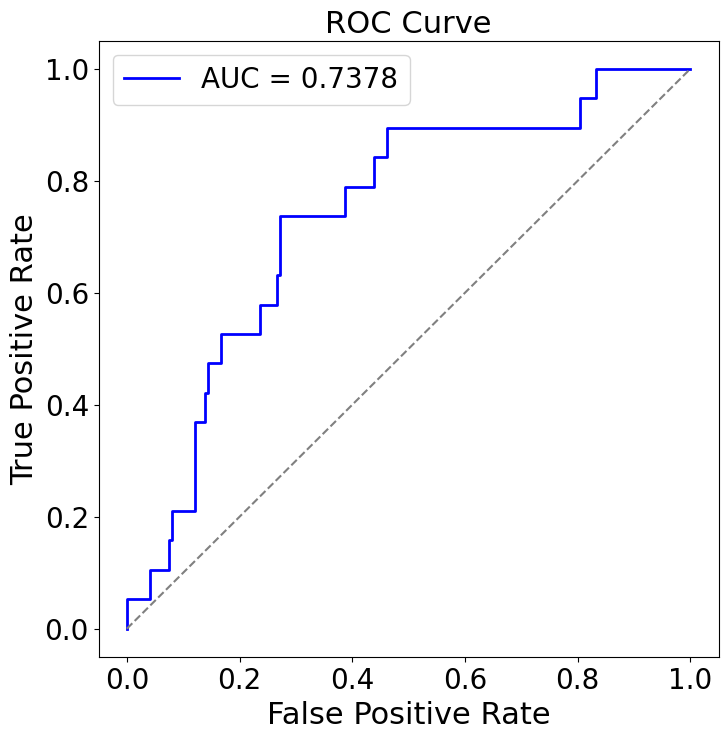

In [18]:
# --- Set model to evaluation mode ---
DNN.eval()

all_targets = []
all_preds = []
all_outputs = []

with torch.no_grad():
    for features, target in test_loader:
        features = features.to(device)
        target = target.to(device).float().unsqueeze(-1)

        outputs = DNN(features)
        preds = (outputs > 0.5).float()

        all_targets.append(target.cpu())
        all_preds.append(preds.cpu())
        all_outputs.append(outputs.cpu())

# --- Concatenate all batches ---
all_targets = torch.cat(all_targets).squeeze().long().numpy()  # integers 0/1
all_preds = torch.cat(all_preds).squeeze().long().numpy()
all_outputs = torch.cat(all_outputs).squeeze().numpy()             # floats in [0,1]

# --- Sanity check ---
print(all_targets.shape, all_preds.shape, all_outputs.shape)
print(np.unique(all_targets))  # should be [0,1]

# --- Compute Metrics ---
cm = confusion_matrix(all_targets, all_preds)
auc_score = roc_auc_score(all_targets, all_outputs)  # should work now
f1 = f1_score(all_targets, all_preds)
acc = accuracy_score(all_targets, all_preds)

# Critical Success Index (CSI)
tp = cm[1,1]
fn = cm[1,0]
fp = cm[0,1]
csi = tp / (tp + fn + fp)

print(f"AUC: {auc_score:.4f}, F1: {f1:.4f}, Accuracy: {acc:.4f}, CSI: {csi:.4f}")

# --- Plot Confusion Matrix ---
plt.figure(figsize=(6,6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    annot_kws={"size": 18}  # larger annotation text
)
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('Actual', fontsize=18)
plt.title('Confusion Matrix', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('binary_PQC_confusion.png')
plt.show()


# --- Plot ROC Curve ---
fpr, tpr, thresholds = roc_curve(all_targets, all_outputs)
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}', color='blue', linewidth=2)
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate', fontsize=22)
plt.ylabel('True Positive Rate', fontsize=22)
plt.title('ROC Curve', fontsize=22)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('binary_PQC_AUC.png')

plt.show()


# Interpreting Results Binary Quantum Model
The above results show a significant improvement over any of the previous models. An AUC above 0.7 is unheard of for this problem.

# The Multi Class Quantum Model
The final model is a full quantum model using a PQC and predicting the EF category 0-3

Single state shape: torch.Size([256])
Batch output shape: torch.Size([16, 256])


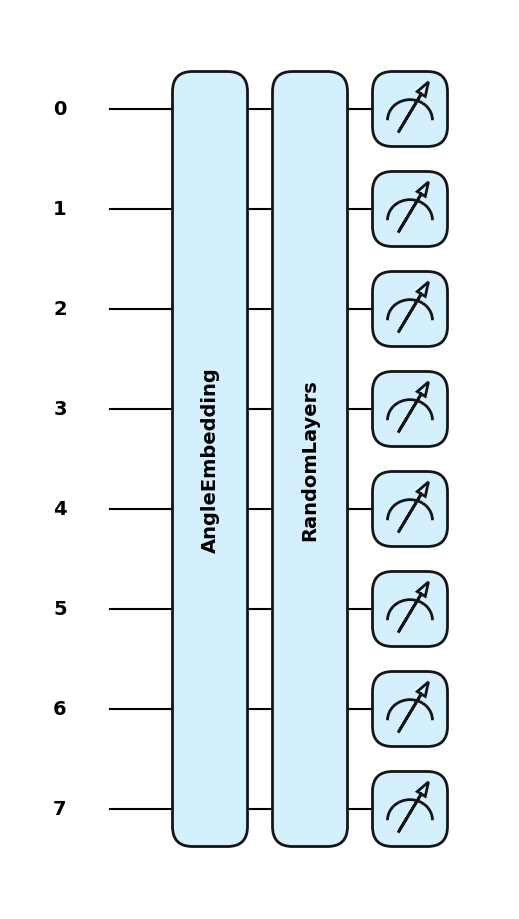

In [19]:
# Data paths
TRAIN_FILE = '../Data/2025-Quantathon-Tornado-Q-training_data-640-examples.xlsx'
TEST_FILE = '../Data/2025-Quantum-Tornado-Q-test_data-200-examples.xlsx'
VALIDATION_FILE = '../Data/2025-Quantum-Tornado-validation_data-160-examples.xlsx'

# Load training data
df_train = pd.read_excel(TRAIN_FILE)
# Load test data
df_test = pd.read_excel(TEST_FILE)
# Load validation data
df_val = pd.read_excel(VALIDATION_FILE)

# Quantum device and parameters
n_qubits = 8
n_layers = 1
dev = qml.device("default.qubit", wires=n_qubits)

# Using Random Layers PQC
USE_RANDOM = True

if USE_RANDOM:
    # RandomLayers expects shape (n_layers, n_rotations_per_layer)
    # For 8 qubits, each layer typically has 3 * 8 = 24 rotations
    rand_params = np.random.uniform(0, 2 * np.pi, (n_layers, n_qubits * 3))
    n_qubits = 8
    n_layers = 1
    phi = nn.Parameter(torch.randn(n_layers, n_qubits, 9))

    @qml.qnode(dev, interface="torch", diff_method="backprop")
    def quantum_feature_embedding(f, phi):
        qml.AngleEmbedding(features=f, wires=range(n_qubits))
        RandomLayers(phi, wires=range(n_qubits), seed=6)
        return qml.state()  # returns 2**n_qubits = 256-dim statevector

# Using Strongly Entangling Layers
else:
    # StronglyEntanglingLayers expects shape (n_layers, n_wires, 3)
    rand_params = np.random.uniform(0, 2 * np.pi, (n_layers, n_qubits, 3))

    @qml.qnode(dev, interface="torch", diff_method="backprop")
    def quantum_feature_embedding(f, phi):
        qml.AngleEmbedding(features=f, wires=range(n_qubits))
        qml.StronglyEntanglingLayers(weights=phi, wires=range(n_qubits))
        return qml.state()

# Batched embedding helper
def quantum_feature_embedding_batch(x_batch, phi, device="cuda"):
    """Apply QNode to batch of inputs -> (B, 256)"""
    outputs = []
    phi = phi.detach().cpu()
    for x in x_batch:
        result = quantum_feature_embedding(x.detach().cpu(), phi)
        outputs.append(result.real.to(device))
    return torch.stack(outputs)

# Test single example
state = quantum_feature_embedding(
    torch.tensor([1/4] * n_qubits, dtype=torch.float32),
    torch.tensor(rand_params, dtype=torch.float32)
)
print("Single state shape:", state.shape)  # (256,)

# Test batch
sample = torch.randn(16, n_qubits)
phi_tensor = torch.tensor(rand_params, dtype=torch.float32)
output = quantum_feature_embedding_batch(sample, phi_tensor, device = device)
print("Batch output shape:", output.shape)  # (16, 256)

# Torch module for integration
class QuantumFeatureEmbeddingBatch(nn.Module):
    def __init__(self, device="cuda"):
        super().__init__()
        self.device = device
        self.phi = nn.Parameter(torch.tensor(
            np.random.uniform(0, 2 * np.pi, (n_layers, n_qubits * 3)), 
            dtype=torch.float32
        ))

    def forward(self, x_batch):
        outputs = []
        phi = self.phi.detach().cpu()
        for x in x_batch:
            result = quantum_feature_embedding(x.detach().cpu(), phi)
            outputs.append(result.real.to(self.device))
        return torch.stack(outputs)

# Visualize
qml.drawer.use_style('pennylane')
fig, ax = qml.draw_mpl(quantum_feature_embedding, level="device")(f=[1/4]*n_qubits, phi=rand_params)
fig.show()


In [20]:
# Multiclass QNN with Quantum Random Layer feature encoder
class MulticlassQNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Encodes features from dataset
        self.feature_encoder = QuantumFeatureEmbeddingBatch(device=device)

        # Classifies based on encoded features
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 4)
        )

    def forward(self, features):
        feats_encoded = self.feature_encoder(features)
        class_probs = self.classifier(feats_encoded.float())

        return class_probs  # Shape: (batch_size, 1)
    
    
    
X_train, y_train, X_test, y_test, X_val, y_val = Preprocess(df_train, df_test, df_val, balance = 'smote', classes = 'multiclass')

print(y_test[:])
print(y_train[:])
print(y_val[:])

train_data = ClassificationDataset(X_train, y_train)
validation_data = ClassificationDataset(X_val, y_val)
test_data = ClassificationDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(validation_data, batch_size=64, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, drop_last=True)

X_batch, y_batch = next(iter(train_loader))

DNN = MulticlassQNN().to(device)

0      1
1      0
2      1
3      0
4      2
      ..
195    1
196    1
197    3
198    0
199    0
Name: ef_class, Length: 200, dtype: int64
0       1
1       0
2       1
3       0
4       1
       ..
1323    3
1324    3
1325    3
1326    3
1327    3
Name: ef_class, Length: 1328, dtype: int64
0      0
1      1
2      2
3      0
4      0
      ..
155    0
156    1
157    0
158    0
159    1
Name: ef_class, Length: 160, dtype: int64


In [21]:
from pathlib import Path
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


load_path = "../Notebooks/models/DNN_model_best_accuracy_RLMulti.pt" # Path to load model

ckpt = torch.load(load_path, map_location=device)

DNN.load_state_dict(ckpt["DNN_state_dict"])  
print("Loaded:", load_path)


Loaded: ../Notebooks/models/DNN_model_best_accuracy_RLMulti.pt


AUC: 0.5577, F1: 0.2928, Accuracy: 0.4792
Class 0 CSI: 0.4640
Class 1 CSI: 0.2857
Class 2 CSI: 0.0488
Class 3 CSI: 0.0000


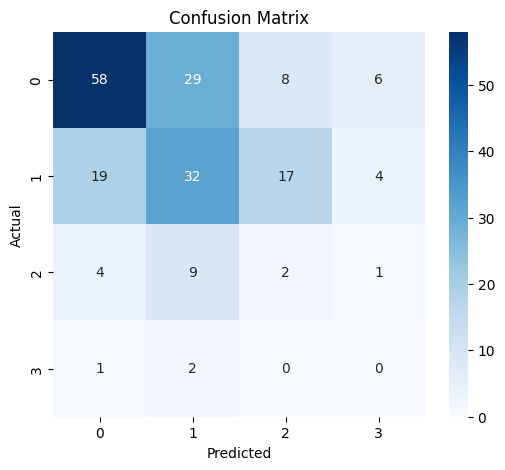

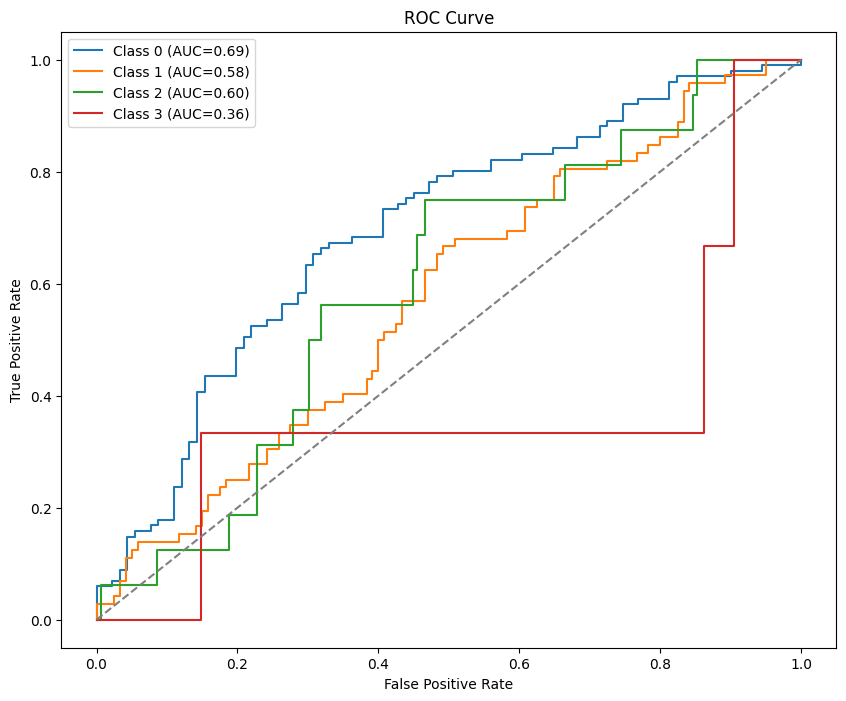

In [22]:
DNN.eval()
all_targets, all_preds, all_probs = [], [], []

with torch.no_grad():
    for features, target in test_loader:
        features = features.to(device)
        target = target.to(device).long()
        outputs = DNN(features)
        
        if outputs.shape[1] == 1:
            # Binary case
            probs = torch.sigmoid(outputs).squeeze(-1)
            preds = (probs > 0.5).long()
        else:
            # Multiclass case
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

        all_targets.append(target.cpu())
        all_preds.append(preds.cpu())
        all_probs.append(probs.cpu())

# Concatenate
all_targets = torch.cat(all_targets).numpy()
all_preds = torch.cat(all_preds).numpy()
all_probs = torch.cat(all_probs).numpy()

# Metrics
cm = confusion_matrix(all_targets, all_preds)
acc = accuracy_score(all_targets, all_preds)
if outputs.shape[1] == 1:
    f1 = f1_score(all_targets, all_preds)
    auc_score = roc_auc_score(all_targets, all_probs)
    csi = cm[1,1] / (cm[1,1] + cm[1,0] + cm[0,1])
else:
    num_classes = outputs.shape[1]
    f1 = f1_score(all_targets, all_preds, average='macro')
    auc_score = roc_auc_score(np.eye(num_classes)[all_targets], all_probs, multi_class='ovr')
    csi = []
    for i in range(num_classes):
        tp = cm[i,i]
        fn = cm[i,:].sum() - tp
        fp = cm[:,i].sum() - tp
        csi.append(tp / (tp + fn + fp) if (tp+fn+fp)>0 else 0)

# Print metrics
print(f"AUC: {auc_score:.4f}, F1: {f1:.4f}, Accuracy: {acc:.4f}")
if outputs.shape[1] > 1:
    for i, c in enumerate(csi):
        print(f"Class {i} CSI: {c:.4f}")
else:
    print(f"CSI: {csi:.4f}")

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC curve
plt.figure(figsize=(10,8))
if outputs.shape[1] == 1:
    fpr, tpr, _ = roc_curve(all_targets, all_probs)
    plt.plot(fpr, tpr, label=f'AUC={auc_score:.4f}')
else:
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve((all_targets==i).astype(int), all_probs[:,i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


# Interpreting Result Quantum Multi Class
As we can see above, the results for this quantum multiclass model are quite poor. Undoubtedly, our best results are the binary PQC, which are the results displayed before this one.


# Future Work (because we ran out of time)
As seen in one of the earlier cells, we have a quantum kernel trained from the strong tornadoes in the provided datasets. The next (and final) step is to take the output from our fully quantum binary classification model, which is our best performing model, and feed it into the quantum kernel. To clarify, the goal is to idenfity the strongest tornadoes, which are EF 3 in our dataset. This is because weather emergenecy alerts may beed to be issued for these tornadoe.

With this goal in mind, we can use the quantum kernel estimation as a second binary classifier, separating the EF 2 tornadoes from the EF3 tornadoes. Here is a simple summary of what we did, excluding the classical and hybrid models:

preprocess data -> train binary PQC on all available data AND train quantum kernel on strong tornadoes.

The entire pipeline, once the models are trained is as follows:
Classify tornado using binary PQC -> if classified as strong, feed into quantum kernel -> if classified as strong again, issue emergency alert.